\begin{tabular}{rrrrrr}
\toprule
Writers & Blob Size (Bytes) & C++ Avg. Latency (ns) & Python Avg. Latency (ns) & C++ Throughput (Gbps) & Python Throughput (Gbps) \\
\midrule
1 & 100 & 47.9 & 3,630.3 & 16.7 & 0.2 \\
1 & 1,000 & 211.8 & 1,214.9 & 37.8 & 6.6 \\
1 & 10,000 & 1,294.1 & 2,404.8 & 61.8 & 33.3 \\
1 & 50,000 & 6,070.7 & 6,977.7 & 65.9 & 57.3 \\
2 & 100 & 79.5 & 3,127.9 & 10.1 & 0.3 \\
2 & 1,000 & 249.3 & 1,135.7 & 32.1 & 7.0 \\
2 & 10,000 & 1,494.0 & 3,047.4 & 53.5 & 26.3 \\
2 & 50,000 & 4,443.1 & 7,210.2 & 90.0 & 55.5 \\
4 & 100 & 165.9 & 3,015.7 & 4.8 & 0.3 \\
4 & 1,000 & 286.9 & 1,174.0 & 27.9 & 6.8 \\
4 & 10,000 & 1,543.8 & 6,937.1 & 51.8 & 11.5 \\
4 & 50,000 & 4,410.8 & 22,248.9 & 90.7 & 18.0 \\
8 & 100 & 180.6 & 2,433.1 & 4.4 & 0.3 \\
8 & 1,000 & 310.2 & 1,103.5 & 25.8 & 7.2 \\
8 & 10,000 & 3,742.1 & 8,497.1 & 21.4 & 9.4 \\
8 & 50,000 & 5,997.9 & 40,621.5 & 66.7 & 9.8 \\
\bottomrule
\end{tabular}



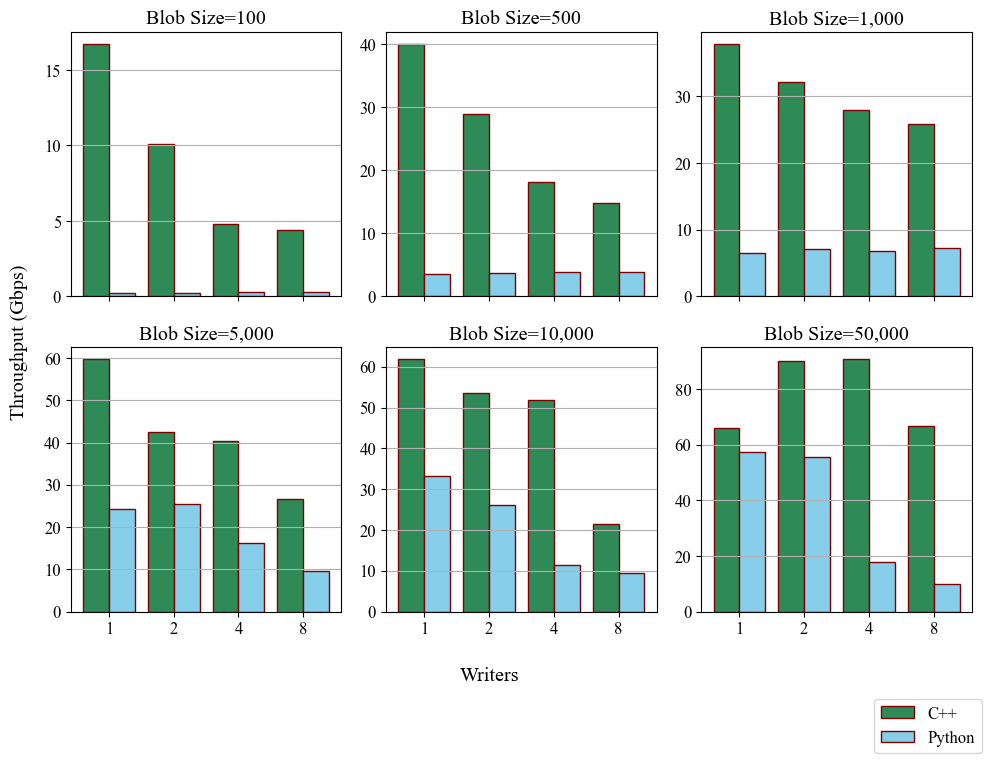

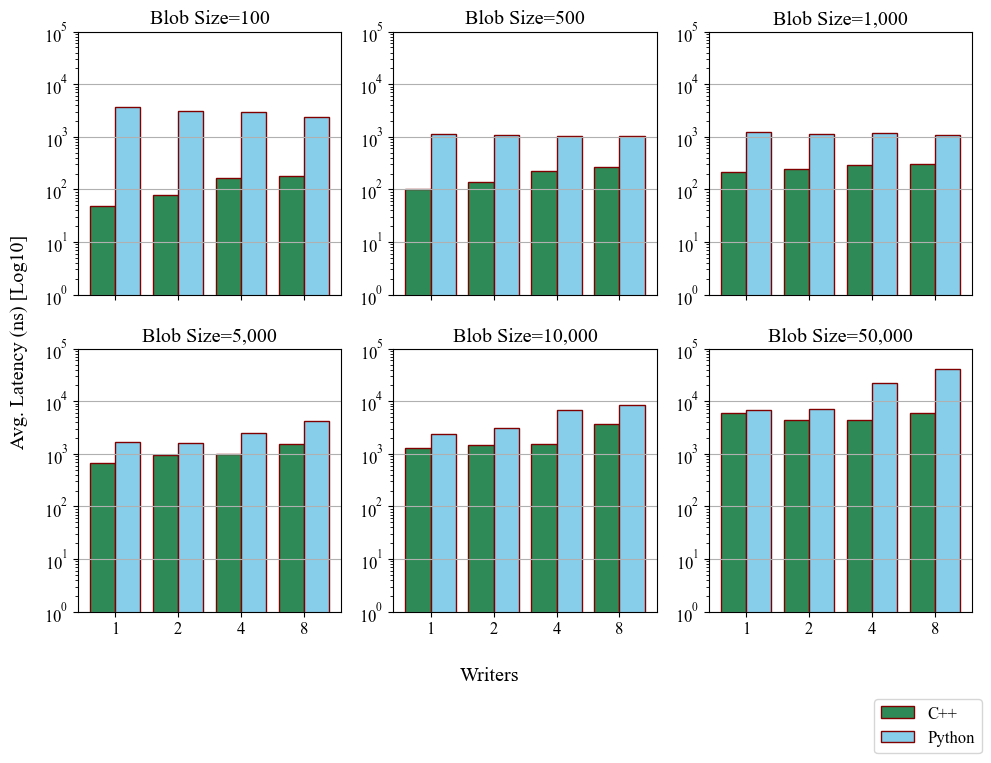

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"
pd.set_option('mode.chained_assignment', None)

G = 10**9
M = 10**6

def update_df(df):
    df['avg_latency'] = (df['Time']/df['Entries'])
    df['Gbs'] = df['Entries']*8*df['Size']/G
    df['Gbps'] = df['Gbs'] / (df['Time'] / G)
    
def create_plots(df1, df2, ytitle, val_col, filename, logscale = False, ylim = None):
    
    fig, ax = plt.subplots(2, 3, sharex=True, figsize=(10,7))
    writers = list(set(df1['Size']))
    writers.sort()

    c = 0
    for i in range(2):
        for j in range(3):
            sub = ax[i][j]
            w = writers[c]
            sub_df1 = df1[df1['Size'] == w]
            sub_df2 = df2[df2['Size'] == w]
            labels = ['{:,}'.format(value) for value in sub_df1['Writers']]
            x = np.arange(len(labels))
            sub.bar(x - 0.2 ,list(sub_df1[val_col].values), color ='seagreen', width = 0.4, label='C++', edgecolor='maroon')
            sub.bar(x + 0.2 ,list(sub_df2[val_col].values), color ='skyblue', width = 0.4, label='Python', edgecolor='maroon')
            sub.set_xticks(x)
            sub.set_title(f"Blob Size={'{:,}'.format(w)}")
            if logscale:
                sub.set_yscale('log')
            if ylim:
                sub.set_ylim(ylim[0], ylim[1])
            sub.set_xticklabels(labels)
            sub.grid(axis='y')
            c+=1 

    fig.supxlabel('Writers')
    fig.supylabel(ytitle)
    handles, labs = ax[0][0].get_legend_handles_labels()
    fig.legend(handles, labs, loc='lower right', bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure)
    
    fig.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

cpp_df = pd.read_csv("../test-results/pc_test.csv")
py_df = pd.read_csv("../test-results/py_pc_test.csv")
update_df(cpp_df)
update_df(py_df)

create_plots(cpp_df, py_df, 'Throughput (Gbps)', 'Gbps', "../test-results/pc_test_throughput.png")
create_plots(cpp_df, py_df, 'Avg. Latency (ns) [Log10]', 'avg_latency', "../test-results/pc_test_latency.png", True,ylim=[1, 10**5])


columns = ['Entries', 'Writers', 'Size', 'avg_latency', 'Gbps']
cpp_df = cpp_df[columns]
py_df = py_df[columns]
py_df.rename(columns={'avg_latency': 'py_avg_latency', 'Gbps': 'py_Gbps'}, inplace=True)


py_df.set_index(['Entries', 'Writers', 'Size'], inplace=True)
cpp_df.set_index(['Entries', 'Writers', 'Size'], inplace=True)
out_df = cpp_df.join(py_df).reset_index()



table_bytes = [100, 1000, 10000, 50000]
out_df = out_df[out_df['Size'].isin(table_bytes)]

out_df = out_df[["Writers", "Size", "avg_latency", "py_avg_latency", "Gbps", "py_Gbps"]]
out_df.rename(columns={"Size": "Blob Size (Bytes)", "avg_latency": "C++ Avg. Latency (ns)",
                      "py_avg_latency": "Python Avg. Latency (ns)", 
                      "Gbps": "C++ Throughput (Gbps)", "py_Gbps": "Python Throughput (Gbps)"}, inplace=True)
print(out_df.to_latex(index=False, float_format="{:,.1f}".format, formatters={"Blob Size (Bytes)": "{:,}".format}))
